## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(map(str.lower, text))

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-22 18:25:56--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.4’

onegin.txt.4        100%[===================>] 256,37K  --.-KB/s    in 0,08s   

2021-12-22 18:25:57 (2,99 MB/s) - ‘onegin.txt.4’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(map(str.lower, text))

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(" ".join(text)))

In [7]:
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
token_to_idx = {token: index for index, token in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {index: token for token, index in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F


class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def init_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.init_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [10]:
def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts text into rnn-digestable matrix"""

    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [11]:
def train_rnn(rnn_model, optimizer, loss_func, text, num_epochs: int = 10):
    history = []

    for epoch in range(num_epochs):
        idx_start = np.random.randint(0, len(text) - MAX_LENGTH)
        batch_ix = to_matrix([text[idx_start: idx_start + MAX_LENGTH]], max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logp_seq = rnn_loop(char_rnn, batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = loss_func(predictions_logp.reshape(-1, num_tokens), actual_next_tokens.reshape(-1))

        # train with backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(loss.data.numpy())
    
    return rnn_model, history

In [20]:
MAX_LENGTH = 32
num_tokens = len(tokens)

In [21]:
import numpy as np
from random import sample

In [36]:
char_rnn = CharRNNCell()
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=1e-5, weight_decay=0.1)
# optimizer = torch.optim.SGD(char_rnn.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.NLLLoss()

In [37]:
char_rnn, history = train_rnn(char_rnn, optimizer, loss_func, text, num_epochs=2000)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

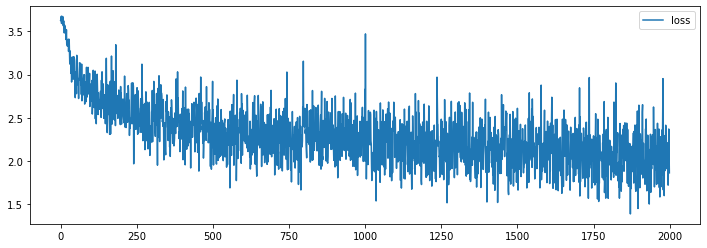

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
plt.plot(history, label='loss')
plt.legend()
plt.show()

In [60]:
# Your plot code here

In [96]:
def generate_sample(char_rnn, seed_phrase='', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.init_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1].to(device), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [64]:
for i in range(10):
    print(generate_sample(char_rnn, seed_phrase=" "))

 clold when winev'st noubst eye 
 his now some thou horbjese ale 
 ulllt oundrigove towor breves b
 piongun;
  may then best as hea
 love sichais foring up livelss 
 too hand as nexligs,
  trot sum
 krle i ounchis who unsie i so h
 i
    mate my hily form of sepp
 vates histind silest by love ha
 mis mw that my doosn noteng bes


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [67]:
MAX_LENGTH

32

In [84]:
class LSTM(nn.Module):
    def __init__(self, num_tokens, embedding_dim, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_tokens = num_tokens
        
        self.embedding = nn.Embedding(num_tokens, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_tokens)

    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        out = self.embedding(X)
        out, (h, c) = self.lstm(out, (h, c))
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = out.view(-1, X.size(1), self.num_tokens)
        out = out[:, -1]
        
        return out, h, c

    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [85]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [86]:
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 3

In [87]:
model = LSTM(num_tokens, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [88]:
model, history = train_rnn(model, optimizer, criterion, text, num_epochs=20)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [97]:
for i in range(10):
    print(generate_sample(model, seed_phrase=" "))

RuntimeError: input must have 3 dimensions, got 2

In [ ]:
model.init_state

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)